In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_info = gen_dataInfo_from_tfCube(redshift=0.2, sini=0.8, g1=0.05, slitAngles=[0.0])

redshift : 0.2
g1 : 0.05
half_light_radius : 0.5
vcirc : 200.0
sini : 0.8
slitWidth : 0.02
slitAngles : [0.0]


returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
total tfCube time: 4.741626977920532 (sec)
total getSlitSpectra time: 1.2492220401763916 (sec)


2D spec dimension: (256, 256, 160)
image dimension: (128, 128)
image variance: 4.4871392798303424e-08


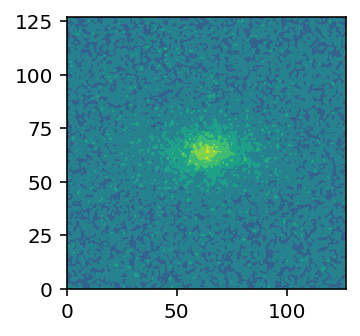

In [3]:
# dimension setting
print("2D spec dimension:", data_info['ModelCube'].shape)
print("image dimension:", data_info['image'].shape)
print("image variance:", data_info['image_variance'])

# check image
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.contourf(data_info['image'])

# Image 

In [4]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ImageFit.py

In [5]:
ImageFit = ImageFit(data_info=data_info)

In [6]:
# check : data model consistency 
model_image = ImageFit.model_image(e_obs=1, half_light_radius=0.5)

print("data signal", ImageFit.image[63,63])
print("model signal", model_image[63,63])

data signal 0.0014495603
model signal 0.0014611796


In [7]:
chainImage_info = ImageFit.run_MCMC(Nwalker=50, Nsteps=1000)

100%|██████████| 1000/1000 [01:07<00:00, 14.76it/s]

Total MCMC time (mins): 1.1302737951278687


In [8]:
Chain_Image = ChainTool(chainImage_info, Nburn=30000, Nend=50000)

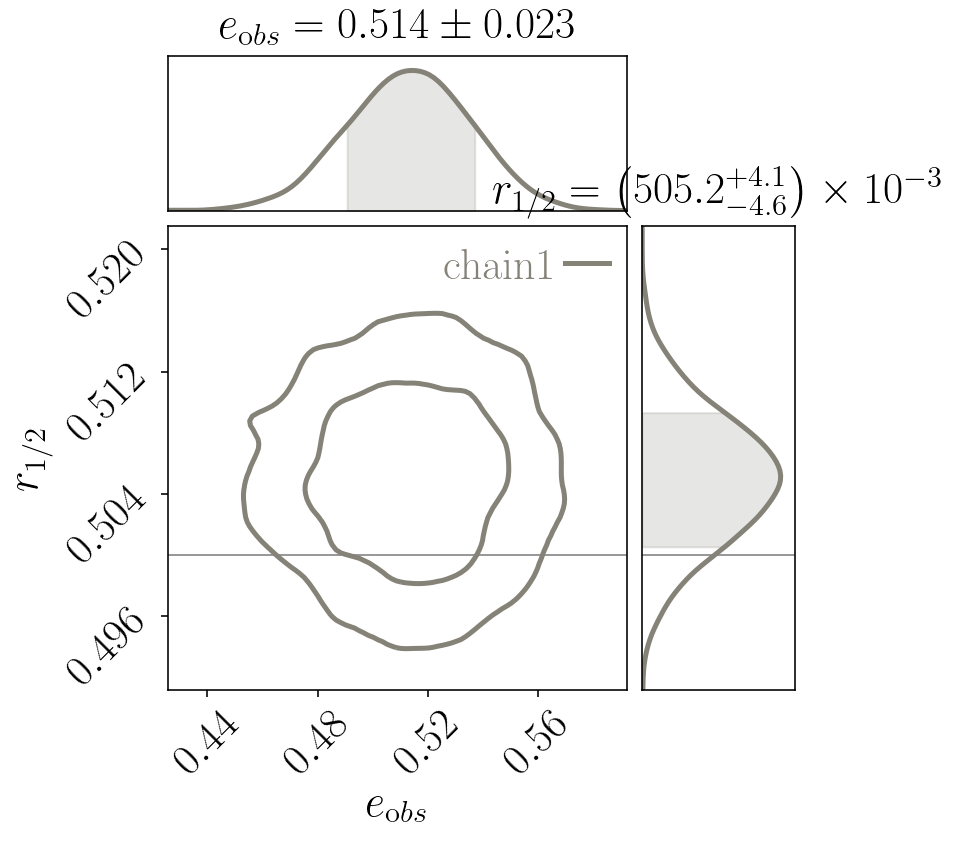

In [9]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['e_obs','half_light_radius']

parID1,parName1,par_x1 = Chain_Image.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_Image.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain1}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=[None,0.5]) #, truth=par_x1

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

In [15]:
bestfit_e_obs = Chain_Image.par_bestfit(select_par_key=['e_obs'], statistics='max')['e_obs'][1]
bestfit_e_obs

0.5142843819280943

# 2D spectrum

In [12]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py

In [16]:
# init Fit tool
RotFit = RotationCurveFit(data_info, active_par_key = ['vscale','vcirc','sini'], e_obs=bestfit_e_obs)

time cost in gaussFit_spec2D: 0.21132373809814453 (secs)


In [17]:
# find fitting parameter using optimizer
params_rot = RotFit.optFit_rotation_curve(RotFit.gaussfit_peakLambda)
params_rot

{'vscale': 0.4987170947797582,
 'r_0': -9.999999999999999e-09,
 'vcirc': 199.9973264065448,
 'v_0': -7.062638031558328e-23,
 'redshift': 0.19999999999999998,
 'sini': 0.8002491723155833}

In [18]:
# find fitting parameters using MCMC (get error bars as well)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:11<00:00, 255.25it/s]

Total MCMC time (mins): 0.19604138135910035


In [20]:
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

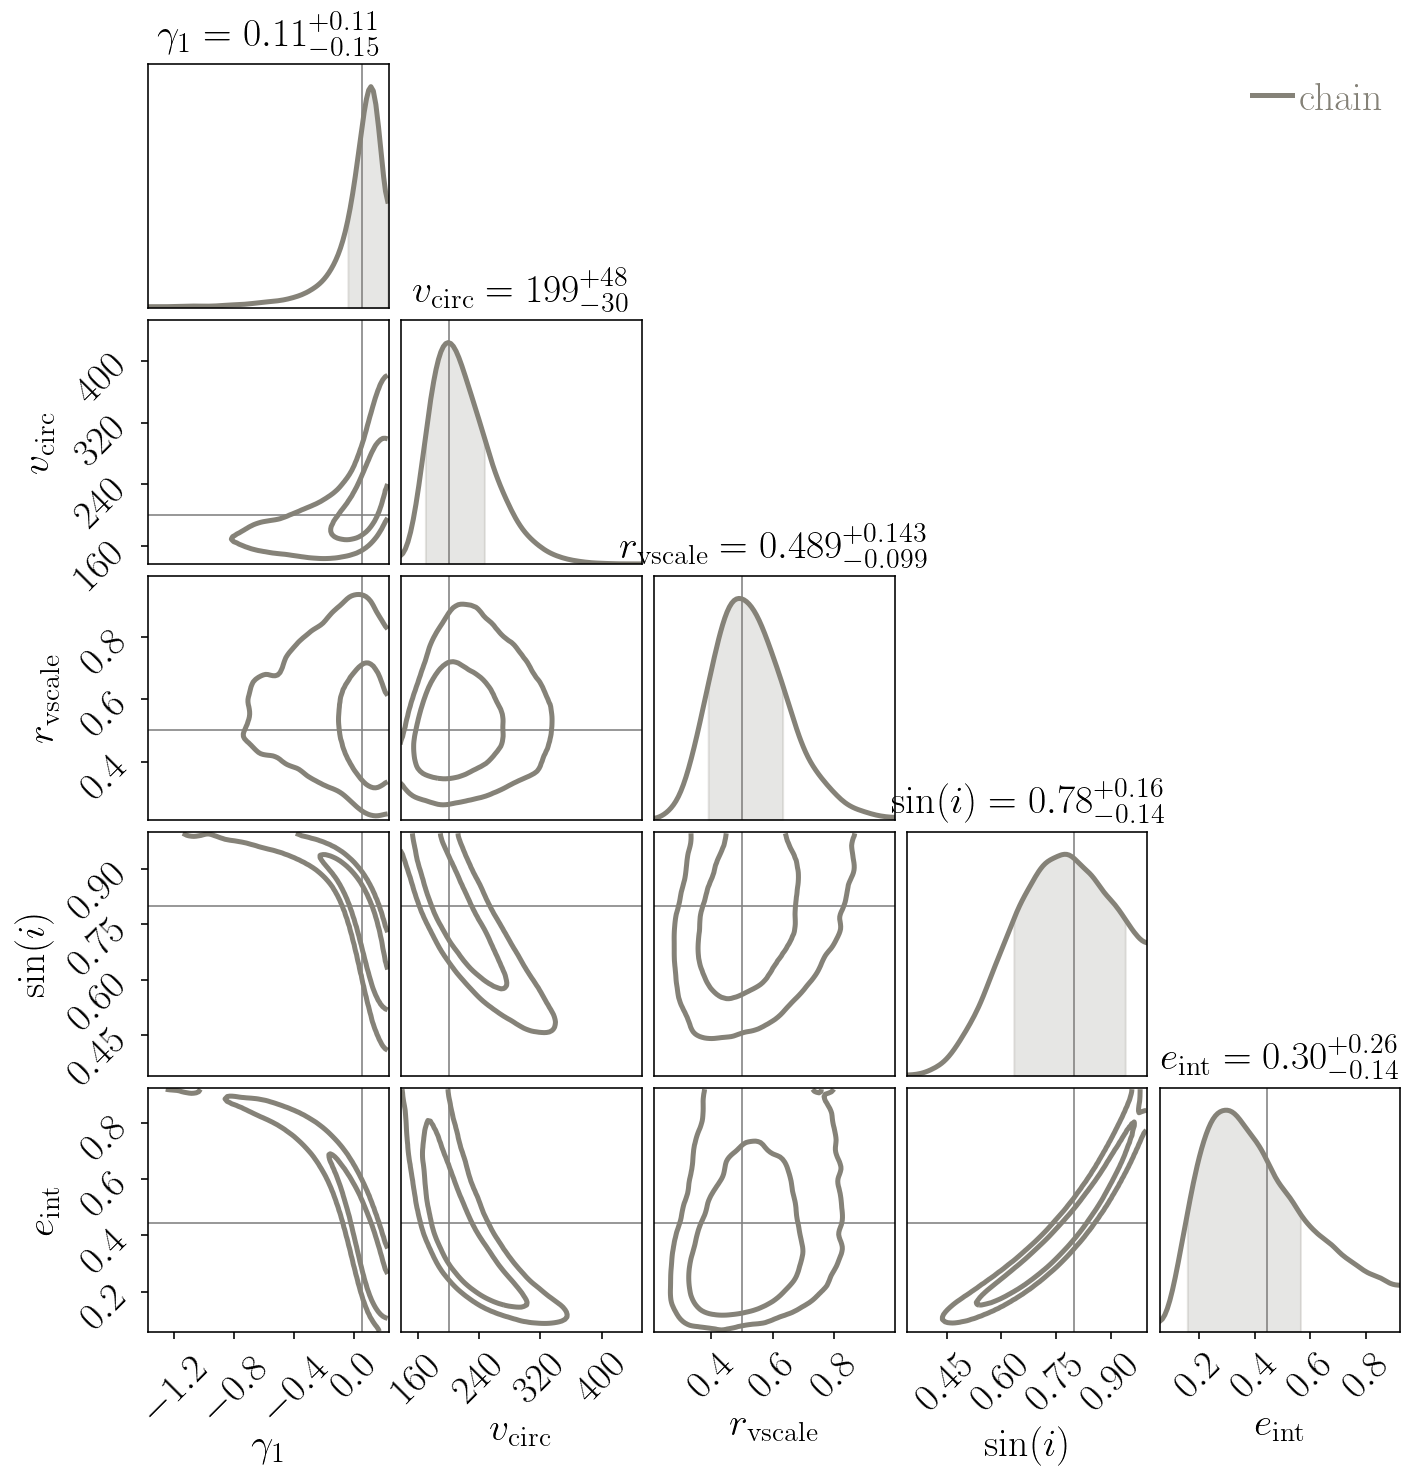

In [23]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['g1','vcirc','vscale','sini','e_int']

parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name="$\mathrm{chain}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

# ---- END ----

In [40]:
import emcee
import numpy as np

def log_prior(params):
    return -0.5 * np.sum(params**2)

def log_like(params):
    return -0.5 * np.sum((params / 0.1)**2)

def log_prob(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    ll = log_like(params)
    if not np.isfinite(ll):
        return lp, -np.inf
    return lp + ll, lp

coords = np.random.randn(32, 3)
nwalkers, ndim = coords.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(coords, 100)

log_prior_samps = sampler.get_blobs()
flat_log_prior_samps = sampler.get_blobs(flat=True)

print(log_prior_samps.shape)  # (100, 32)
print(flat_log_prior_samps.shape)  # (3200,)

(100, 32)
(3200,)


In [42]:
log_prior_samps.shape

(100, 32)

In [55]:
sampler.get_last_sample().coords

array([[-0.18211351, -0.02419586,  0.08111163],
       [ 0.05388631,  0.17348709,  0.06160149],
       [ 0.03253224,  0.16563603,  0.03825565],
       [ 0.00552021,  0.10395987,  0.11037894],
       [ 0.09323275, -0.05420898,  0.03238677],
       [ 0.01320264, -0.10262181,  0.20187082],
       [ 0.03150554, -0.06423033, -0.01189417],
       [-0.10116186,  0.01879847,  0.01701796],
       [-0.03721856, -0.10280623, -0.0212417 ],
       [ 0.09980687,  0.09142838, -0.0039866 ],
       [-0.02482596, -0.08275787,  0.03948401],
       [-0.08301404,  0.06062799, -0.07115029],
       [ 0.11886086, -0.00303581, -0.08195297],
       [ 0.10322922, -0.07717063, -0.06887425],
       [ 0.04914827, -0.02681263,  0.05047899],
       [-0.01463862, -0.03426284,  0.01112923],
       [-0.06069712, -0.08576041, -0.01517319],
       [-0.11430592, -0.00972039,  0.01669165],
       [-0.14880192, -0.01660536, -0.01939631],
       [-0.03310857,  0.11699321, -0.02949452],
       [-0.13015052, -0.14955372,  0.005